<a href="https://colab.research.google.com/github/AgentZero2483/Algorithm-Trading/blob/main/Algotrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your Ticker: sq
sq


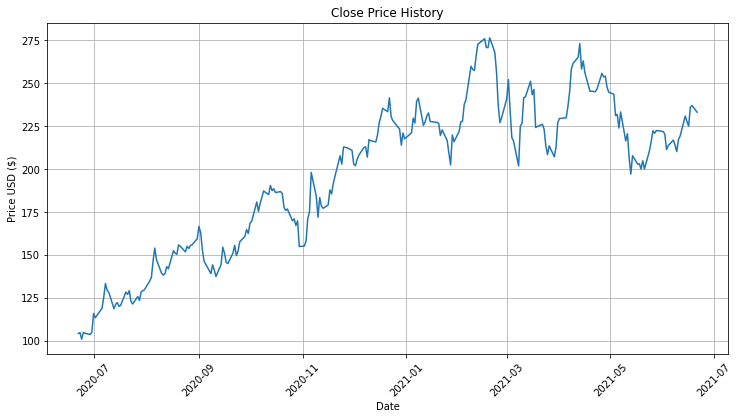

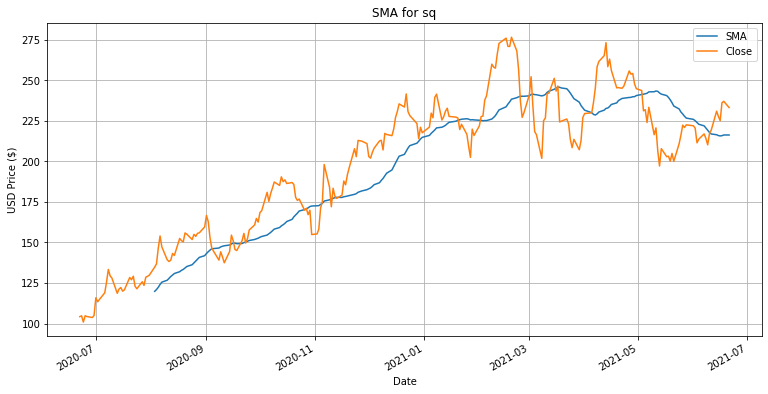

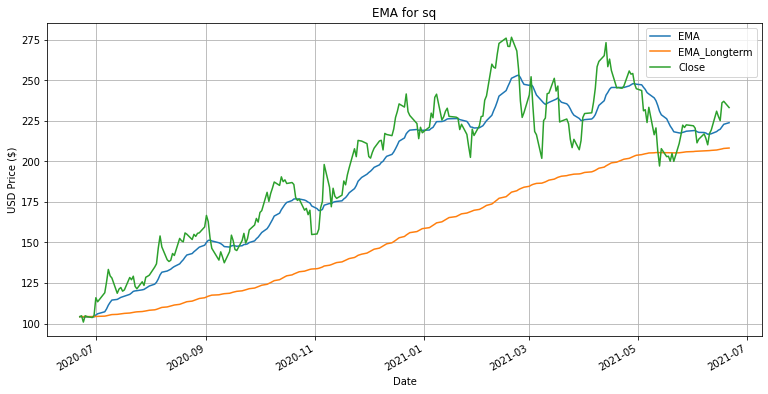

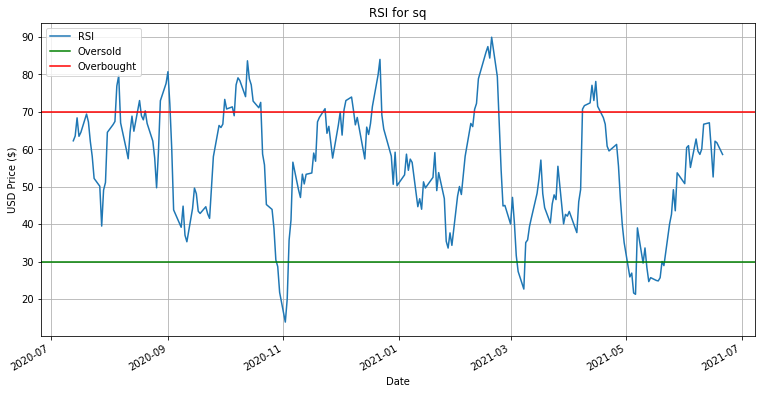

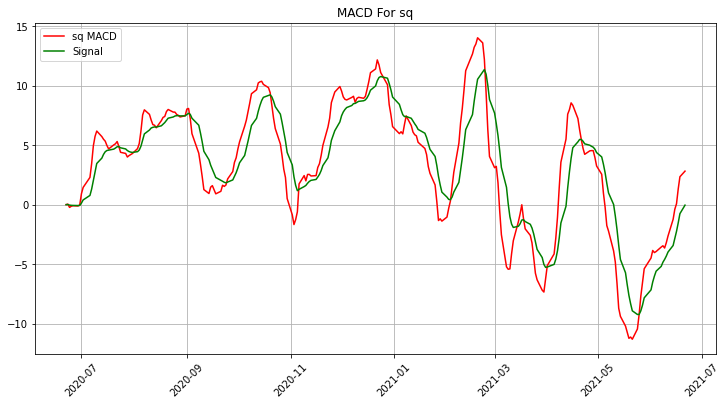

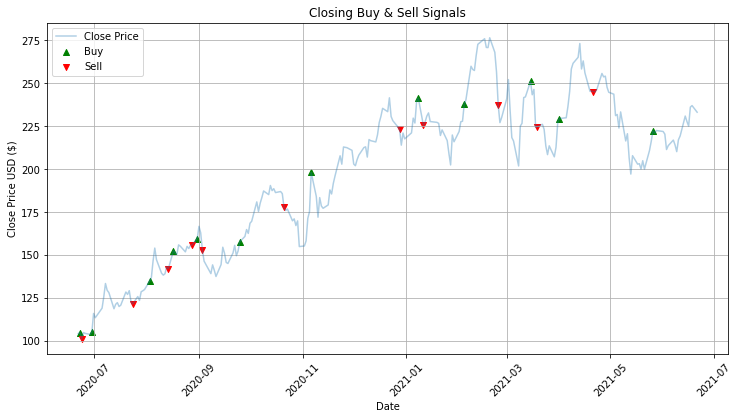

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime

ticker = input("Enter your Ticker: ") #'TSLA'
print(ticker)

current_time = datetime.datetime.now() 
year = current_time.year
month = current_time.month
day = current_time.day
hour = current_time.hour
minute = current_time.minute


#datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])
period1 = int(time.mktime(datetime.datetime(2020, 6, 22, 23, 59).timetuple())) #'1516406400'
#time.mktime converts our ouptput into second values
period2 = int(time.mktime(datetime.datetime(year, month, day, hour, minute).timetuple())) #'1624147200'
interval = '1d' #'1wk' '1m'

#date ranges are provided in seconds, so when we provide date ranges we must convert them to seconds
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

df = pd.read_csv(query_string)
df

df = df.set_index(pd.DatetimeIndex(df['Date'].values))
df
#date: 2010-06-29 - 2020-02-03

#Show stock price
plt.figure(figsize=(12.2, 6.1))
plt.plot(df['Close'], label='Close')
plt.xticks(rotation=45)
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.grid(True)
plt.show()


#Create functions to calculate indicators
#SMA Simple Moving Average Common time periods: (15, 30, 50, 100, 200)
def SMA(data, period=30, column='Close'):
    return data[column].rolling(window=period).mean()
    #rolling provides rolling window calculations.

#EMA Exponential Moving Average
def EMA(data, period=20, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()
    #EW (exponential weighted  functions).
    #Available EW functions: mean(), var(), std(), corr(), cov().

#EMA_Longterm Exponential Moving Average
def EMA_Long(data, period=200, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

#Create function to compute RSI (Relative Strength Index)
def RSI(data, period=14, column='Close'):
    delta=data[column].diff(1)
    #diff used to find descrete difference over the column axis with a period volue = to 1(whatever is inside)
    delta = delta[1:] #gets rid of first row
    up = delta.copy() #makes copy of objects indecies and data
    down = delta.copy()
    up[up<0]=0
    down[down>0]=0
    data['up'] = up
    data['down'] = down
    AVG_Gain = SMA(data, period, column = 'up')
    AVG_Loss = abs(SMA(data, period, column = 'down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0/(1.0 + RS))
    
    data['RSI'] = RSI
    
    return data


#Create data set
RSI(df)
df['SMA'] = SMA(df)
df['EMA'] = EMA(df)
df['EMA_Longterm'] = EMA_Long(df)

#Plot our SMA chart
#Create a list of columns to keep
SMA_columnlist = ['SMA', 'Close']
df[SMA_columnlist].plot(figsize=(12.8, 6.4 ))
plt.title(f'SMA for {ticker}')
plt.ylabel('USD Price ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()
#The key points of reference are when the SMA crosses over the pricing candlesticks. 
#If prices are going up and a crossover occurs, that is viewed as a “Buy” signal, and vice-versa. An SMA is often “teamed” with a faster or slower SMA. 
#In these cases, the crossovers of the SMA lines become a key point of reference.


#Plot our EMA chart
#Create a list of columns to keep
EMA_columnlist = ['EMA', 'EMA_Longterm', 'Close']
df[EMA_columnlist].plot(figsize=(12.8, 6.4 ))
plt.title(f'EMA for {ticker}')
plt.ylabel('USD Price ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

#Plot our RSI chart
#Create a list of columns to keep
RSI_columnlist = ['RSI']
df[RSI_columnlist].plot(figsize=(12.8, 6.4 ))
plt.axhline(y = 30, label='Oversold', color = 'green', linestyle = '-')
plt.axhline(y = 70, label='Overbought', color = 'red', linestyle = '-')
plt.title(f'RSI for {ticker}')
plt.ylabel('USD Price ($)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

#Calculate MACD and Signal line indicators
#Calculate Shorterm EMA
ShortEMA = df.Close.ewm(span=12, adjust=False).mean()
#Calculate the Longterm EMA
LongEMA = df.Close.ewm(span=26, adjust=False).mean()
#Calculate Moving average convergence/Divergence
MACD = (ShortEMA - LongEMA)
#Calculate Signal line
signal= MACD.ewm(span=9, adjust=False).mean()

#Plot Our MACD chart
plt.figure(figsize=(12.2, 6.1))
plt.xticks(rotation=45)
plt.plot(df.index, MACD, label = f'{ticker} MACD', color = 'red')
plt.plot(df.index, signal, label = 'Signal', color = 'green')
plt.legend(loc='upper left')
plt.title(f'MACD For {ticker}')
plt.grid(True)
plt.show()

#Create new columns for data
df['MACD'] = MACD
df['Signal Line'] = signal
#Show
df

#Create function when to buy and sell an asset
def buy_sell(signal):
  buy = []
  sell = []
  flag = -1 
  #Tells if price after crossing a specific point rises or decreases. only changes when momentum shift
  
  for i in range(0, len(signal)): #loop through data and go through each row so we can tell when MACD crosses our signal line
    if signal['MACD'][i] > signal['Signal Line'][i]: #Checks if MACD at position i is greater than the signal line at position i
      sell.append(np.nan) #if true append an nan to our sell list
      if flag != 1: #if our flag number is not = 1 we have not been here before
        buy.append(signal['Close'][i]) #Since we have not been here before append the close price at position i
        flag = 1 #set our flag = 1 meaning that we now have been here before
      else:
        buy.append(np.nan) #if we have been here append a nan to our buy list

    elif signal['MACD'][i] < signal['Signal Line'][i]: #Checks if MACD at position i is less than the signal line at position i
      buy.append(np.nan) #if true append an nan to our buy list
      if flag != 0: #if our flag number is not = 0 we have not been here before
        sell.append(signal['Close'][i]) #since we have not been here before we must append our close price at i to our sell list
        flag = 0 #set our flag = 0 meaning we now have been here
      else:
        sell.append(np.nan) #if we have been here append a nan to our buy list


    else: #if anything else append a nan value to both our buy and sell lists
      buy.append(np.nan) 
      sell.append(np.nan)

  return(buy, sell) #return out buy and sell lists

#create a buy and sell column
a = buy_sell(df)
df['Buy_Price'] = a[0]
df['Sell_Price'] = a[1]

#show data
df

#Show stock buy and sell signals visually
plt.figure(figsize=(12.2, 6.1))
plt.xticks(rotation=45)
plt.scatter(df.index, df['Buy_Price'], color='green', label='Buy', marker='^', alpha=1)
plt.scatter(df.index, df['Sell_Price'], color='red', label='Sell', marker='v', alpha=1)
plt.plot(df['Close'], label='Close Price', alpha=0.35)
plt.title('Closing Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

